In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv('Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


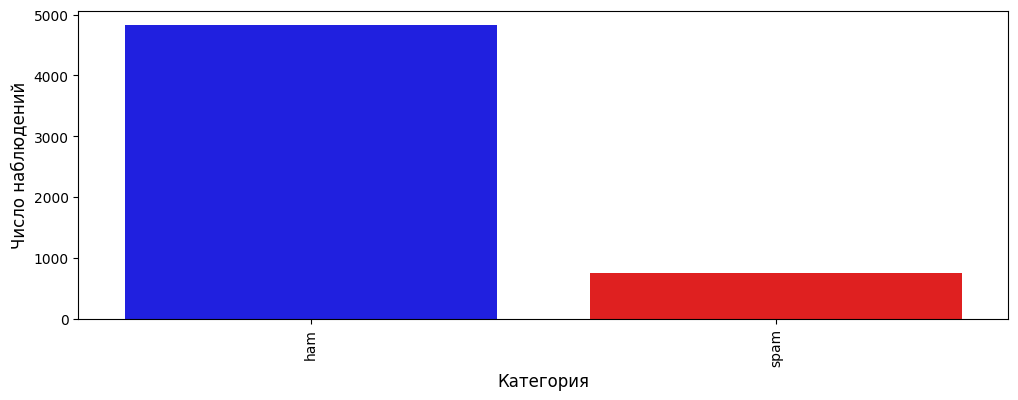

In [4]:
count_text = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count_text, alpha=1, palette=['blue', "red"])
plt.ylabel('Число наблюдений', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.xticks(rotation=90)
plt.show()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #отключения предупреждения

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer('english')

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [6]:
df['Message'] = df['Message'].apply(preprocess_text)

In [7]:
category = pd.get_dummies(df['Category']).values
message = df['Message'].values

In [8]:
tokenizer = Tokenizer(num_words=5000, char_level=False, lower=True)
tokenizer.fit_on_texts(message)
sequences = tokenizer.texts_to_sequences(message)
data = pad_sequences(sequences, maxlen=15)

In [9]:
np.set_printoptions(linewidth=np.inf)
print(data[:20])

[[   0    3 3679  301  617  524 1119   63  250 1120 2507 1121   19 3680   70]
 [   0    0    0    0    0    0    0    0    0    0   10  263  555  370 1634]
 [1956  182 1957   20 1635 1637  209  383  272  800   25  234  222  297 2508]
 [   0    0    0    0    0    0    0   43  173   47  303 2509  222   87   47]
 [   0    0    0    0    0    0    0    0  856   31  384  801  168  150  371]
 [  33  151   40   15  317   37 1638   10  288  800 3681   21   27  152 2510]
 [   0    0    0    0    0    0    0   84  458   15  289  496   15 2511 3682]
 [ 802 1272 1272 1639 1958 1959 1960  385  857  525  689  318  803   75  857]
 [ 145  280 2512  858   85  690   71    1 2513   71  330 2514  412  750  187]
 [ 183  158 1020  398  251  386   39  264   11    1   39  398  169   11 2515]
 [   0    0    0    0  164   30  153   18  154  210 1021  146 1123  348   24]
 [  25 2516   21 1641  201  125   12 2517  178 2518  297   34 1273    6  579]
 [ 243  349   85 2519   25  151   71 2520  222   80 2521  428 25

In [10]:
train_data, test_data, train_category, test_category = train_test_split(data, category, test_size=0.2, random_state=50) 

In [50]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 32, input_length=15))
model.add(LSTM(16, dropout=0.4, recurrent_dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
history = model.fit(train_data, train_category, validation_split=0.2, epochs=5, verbose=1)

Epoch 1/5
112/112 [==============================] - 5s 13ms/step - loss: 0.2956 - accuracy: 0.8951 - val_loss: 0.1248 - val_accuracy: 0.9675
Epoch 2/5
112/112 [==============================] - 1s 11ms/step - loss: 0.0752 - accuracy: 0.9826 - val_loss: 0.0632 - val_accuracy: 0.9854
Epoch 3/5
112/112 [==============================] - 1s 11ms/step - loss: 0.0338 - accuracy: 0.9933 - val_loss: 0.0569 - val_accuracy: 0.9854
Epoch 4/5
112/112 [==============================] - 1s 11ms/step - loss: 0.0223 - accuracy: 0.9955 - val_loss: 0.0559 - val_accuracy: 0.9888
Epoch 5/5
112/112 [==============================] - 1s 11ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 0.0573 - val_accuracy: 0.9877


In [52]:
loss, accuracy = model.evaluate(test_data, test_category, verbose=1)

print(f"Ошибка: {loss}")
print(f"Точность: {accuracy}")

35/35 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 0.9919
Ошибка: 0.04222667217254639
Точность: 0.9919282793998718


In [53]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=-1)

results = pd.DataFrame({
    'True Label': np.argmax(test_category, axis=-1),
    'Predicted Label': predictions
})

total_records = len(results)
mismatch_records = len(results[results['True Label'] != results['Predicted Label']])
percent_loss = mismatch_records / total_records * 100

print(f'Число записей: {total_records}')
print(f'Число не совпадающих результатов: {mismatch_records}')
print(f'Процент ошибочных предсказаний: {percent_loss}')

results.to_csv('results.csv')


35/35 [==============================] - 0s 2ms/step
Число записей: 1115
Число не совпадающих результатов: 9
Процент ошибочных предсказаний: 0.8071748878923767


In [54]:
print(test_data[:5])
print()
text = tokenizer.sequences_to_texts(test_data[:5])
print(text)

[[ 386   46 2478 1630   11  172   39  243   11   20   11  620   34    1  584]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0 2361]
 [   0    0    0    0    0    0    0    0    0    0    0 1258 2447 3365 2448]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   17 1595]
 [ 224  402  243   33  230   25  407  711  909  241   80  956  126 2969 2970]]

['colour phone deliveredtomorrow 300 free minut mobil 100 free text free camcord repli call 08000930705', 'lousi', 'remain bro amongst bros', 'good allow', '500 enter 100 week draw txt music 87066 ts cs www ldew com subs16 1win150ppmx3']


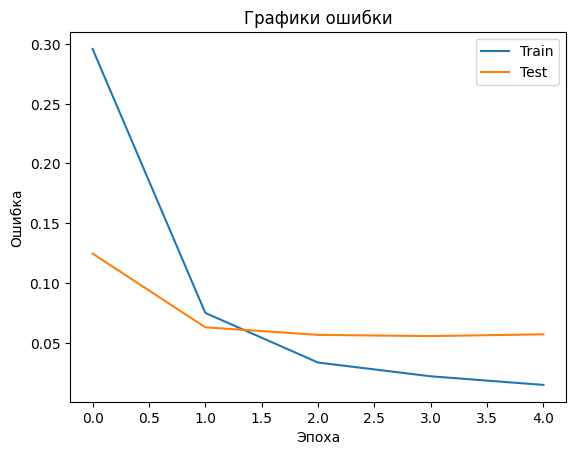

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Графики ошибки')
plt.ylabel('Ошибка')
plt.xlabel('Эпоха')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

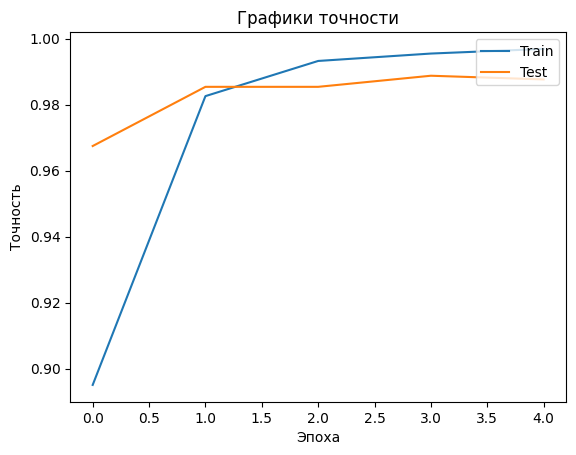

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Графики точности')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

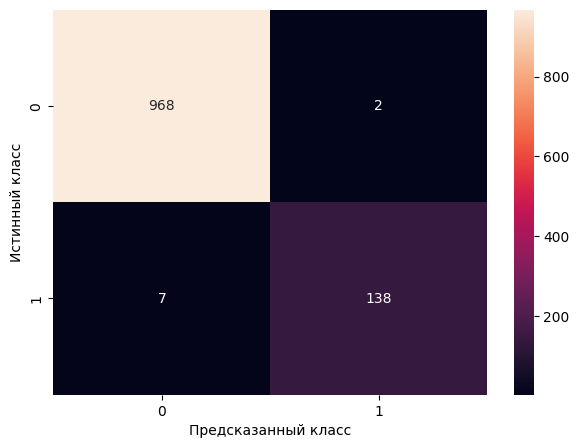

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

df = pd.read_csv('results.csv')
y_true = df['True Label']
y_pred = df['Predicted Label']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

In [59]:
model.save('model_9loss.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 15, 32)            232736    
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 235906 (921.51 KB)
Trainable params: 235906 (921.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
